# Computational Checks
Tim Tyree<br>
8.18.2020

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from numba import njit
#load the libraries
from lib import *

#automate the boring stuff
# from IPython import utils
import time, os, sys, re
beep = lambda x: os.system("echo -n '\\a';sleep 0.2;" * x)
if not 'nb_dir' in globals():
    nb_dir = os.getcwd()
    
%autocall 1
%load_ext autoreload
%autoreload 2

Automatic calling is: Smart


In [68]:
#make plots in darkmode
import seaborn as sns
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

# computational checks for FK model in 2D

In [3]:
def import_fortran_texture(file_name):
    fn = file_name
    data_ic = np.loadtxt(fn)
    cols = ['i','j','u','v','w']
    df = pd.DataFrame(data_ic, columns=cols)
    df.head()
    target_shape = df.describe()[['i','j']].T['max'].values
    ic = df[['u','v','w']].values
    ic = ic.reshape((int(target_shape[0]),int(target_shape[1]),3), order='F')
    return ic

## load and visualize the initial/final buffers

In [22]:
#find file interactively
# print("please select a file from within the desired folder.")
# file = search_for_file()
#MacDirectory: 
# file = '/Users/timothytyree/Documents/GitHub/care/Python/computational-checks/input_half'
#LinuxDirectory:
file = '/home/timothytyree/Documents/GitHub/care/Python/computational-checks/input_half'
# folder=f"{nb_dir}/../Python/computational-checks"

In [23]:
folder_name = os.path.dirname(file)
os.chdir(folder_name)
# retval = !ls

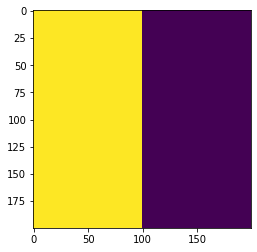

In [24]:
fn = 'input_half'
ic = import_fortran_texture(fn)
plt.imshow(ic[...,0])

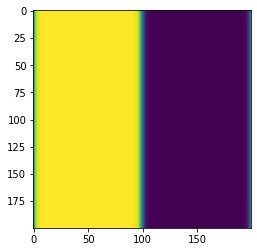

In [25]:
fn = 'output_half'
ic = import_fortran_texture(fn)
plt.imshow(ic[...,0])

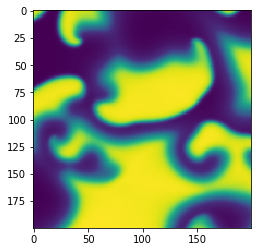

In [26]:
fn = 'input_disorder'
ic = import_fortran_texture(fn)
plt.imshow(ic[...,0])

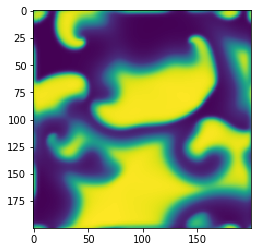

In [27]:
fn = 'output_disorder'
ic = import_fortran_texture(fn)
plt.imshow(ic[...,0])

### visualize cross section of the half io textures

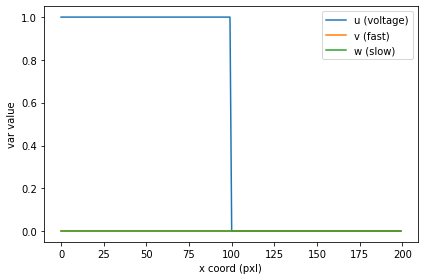

In [9]:
fn = 'input_half'
save_fn = f'fig/{fn}_wj.png'
ic = import_fortran_texture(fn)
save = True

plt.plot(ic[100,:,0], label='u (voltage)')
plt.plot(ic[100,:,2], label='v (fast)')
plt.plot(ic[100,:,1], label='w (slow)')
plt.legend()
plt.xlabel('x coord (pxl)')
plt.ylabel('var value')
if not save:
    plt.show()
else:
    plt.tight_layout()
    plt.savefig(save_fn, dpi = 200)

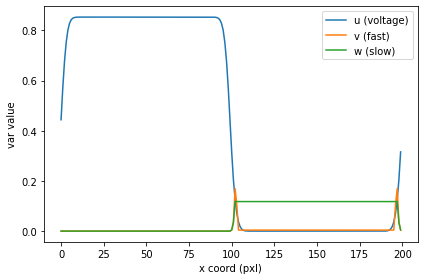

In [10]:
fn = 'output_half'
save_fn = f'fig/{fn}_wj.png'
ic = import_fortran_texture(fn)
save = True

plt.plot(ic[100,:,0], label='u (voltage)')
plt.plot(ic[100,:,1], label='v (fast)')
plt.plot(ic[100,:,2], label='w (slow)')
plt.legend()
plt.xlabel('x coord (pxl)')
plt.ylabel('var value')
if not save:
    plt.show()
else:
    plt.tight_layout()
    plt.savefig(save_fn, dpi = 200)

## define the FK time_step here

In [9]:
# @njit
# def Tanh(x):
# 	'''fast/simple approximatation of the hyperbolic tangent function'''
# 	if ( x < -3.):
# 		return -1.
# 	elif ( x > 3. ):
# 		return 1.
# 	else:
# 		return x*(27.+x*x)/(27.+9.*x*x)

@njit
def Tanh(x):
    return np.math.tanh(x)
    
# /*------------------------------------------------------------------------
#  * applying periodic boundary conditions for each texture call
#  *------------------------------------------------------------------------
#  */
@njit
def pbc(S,x,y):
    '''S=texture with size 512,512,3
    (x, y) pixel coordinates of texture with values 0 to 1.
    tight boundary rounding is in use.'''
    width  = int(S.shape[0])
    height = int(S.shape[1])
    if ( x < 0  ):				# // Left P.B.C.
        x = width - 1
    elif ( x > (width - 1) ):	# // Right P.B.C.
        x = 0
    if( y < 0 ):				# //  Bottom P.B.C.
        y = height - 1
    elif ( y > (height - 1)):	# // Top P.B.C.
        y = 0
    return S[x,y]

@njit
def pbc1(S,x,y):
	'''S=texture with size 512,512,1
	(x, y) pixel coordinates of texture with values 0 to 1.
	tight boundary rounding is in use.'''
	width  = int(S.shape[0])
	height = int(S.shape[1])
	if ( x < 0  ):				# // Left P.B.C.
		x = width - 1
	elif ( x > (width - 1) ):	# // Right P.B.C.
		x = 0
	if( y < 0 ):				# //  Bottom P.B.C.
		y = height - 1
	elif ( y > (height - 1)):	# // Top P.B.C.
		y = 0
	return S[x,y]

# step function
@njit
def step(a,b):
    return 1 if a<=b else 0 # nan yields 1

# /*------------------------------------------------------------------------
#  * time step at a pixel
#  *------------------------------------------------------------------------
#  */
@njit
def time_step_at_pixel(inVfs, x, y):#, h):
    # define parameters
    width    = int(inVfs.shape[0])
    height   = int(inVfs.shape[1])
    DX       = 0.025 #cm/pxl
    DY       = 0.025 #cm/pxl
    cddx     = 1/DX**2
    cddy     = 1/DY**2
    diffCoef = 0.0005 # cm^2 / ms
    C_m      = 1.000  # 􏰎microFarad/cm^2 

    #parameter set 8 of FK model from Fenton & Cherry (2002)
    tau_pv   = 13.03
    tau_v1   = 19.6
    tau_v2   = 1250
    tau_pw   = 800
    tau_mw   = 40
    tau_d    = 0.45# also interesting to try, but not F&C8's 0.45: 0.407#0.40#0.6#
    tau_0    = 12.5
    tau_r    = 33.25
    tau_si   = 29#
    K        = 10
    V_sic    = 0.85#
    V_c      = 0.13
    V_v      = 0.04
    C_si     = 1  # I didn't find this (trivial) multiplicative constant in Fenton & Cherry (2002).  The value C_si = 1 was used in Kaboudian (2019).
    dx, dy   = (1, 1)# (1/512, 1/512) # size of a pixel

    # /*------------------------------------------------------------------------
    #  * reading from textures
    #  *------------------------------------------------------------------------
    #  */
    C = pbc(inVfs, x, y)
    vlt = C[0]#volts
    fig = C[1]#fast var
    sig = C[2]#slow var

    # /*-------------------------------------------------------------------------
    #  * Calculating right hand side vars
    #  *-------------------------------------------------------------------------
    #  */
    p = step(V_c, vlt)
    q = step(V_v, vlt)
    
    #original FK model
    #     tau_mv = (1.0 - q) * tau_v1 + q * tau_v2
    #FK model with tau_v2 and tau_v1 switched
    tau_mv = (1.0 - q) * tau_v2 + q * tau_v1
    
    Ifi = -fig * p * (vlt - V_c) * (1.0 - vlt) / tau_d
    Iso = vlt * (1.0 - p) / tau_0 + p / tau_r

    tn = Tanh(K * (vlt - V_sic))
    Isi = -sig * (1.0 + tn) / (2.0 * tau_si)
    Isi *= C_si
    dFig2dt = (1.0 - p) * (1.0 - fig) / tau_mv - p * fig / tau_pv
    dSig2dt = (1.0 - p) * (1.0 - sig) / tau_mw - p * sig / tau_pw

    #five point stencil
    dVlt2dt = (
        (pbc(inVfs, x + 1, y)[0] - 2.0 * C[0] +
         pbc(inVfs, x - 1, y)[0]) * cddx +
        (pbc(inVfs, x, y + 1)[0] - 2.0 * C[0] +
         pbc(inVfs, x, y - 1)[0]) * cddy)
    dVlt2dt *= diffCoef
    
    #(deprecated) nine point stencil
    # 	dVlt2dt = (1. - 1. / 3.) * (
    # 		(pbc(inVfs, x + 1, y)[0] - 2.0 * C[0] +
    # 		 pbc(inVfs, x - 1, y)[0]) * cddx +
    # 		(pbc(inVfs, x, y + 1)[0] - 2.0 * C[0] +
    # 		 pbc(inVfs, x, y - 1)[0]) * cddy) + (1. / 3.) * 0.5 * (
    # 			 pbc(inVfs, x + 1, y + 1)[0] + pbc(
    # 				 inVfs, x + 1, y - 1)[0] + pbc(inVfs, x - 1, y - 1)[0] +
    # 			 pbc(inVfs, x - 1, y + 1)[0] - 4.0 * C[0]) * (cddx + cddy)
    # 	dVlt2dt *= diffCoef
    
    I_sum = Isi + Ifi + Iso
    dVlt2dt -= I_sum / C_m
    return np.array((dVlt2dt,dFig2dt,dSig2dt),dtype=np.float64)

@njit
def get_time_step (texture, out):
    width  = int(texture.shape[0])
    height = int(texture.shape[1])
    for x in range(width):
        for y in range(height):
            out[x,y] = time_step_at_pixel(texture,x,y)

@njit # or perhaps @jit, which probably won't speed up time_step
def time_step (texture, h, zero_txt):
    dtexture_dt = zero_txt.copy()
    get_time_step(texture, dtexture_dt)
    texture += h * dtexture_dt

## load half ic and apply my time_step

In [32]:
fn = 'input_half'
save_fn = f'fig/{fn}_wj.png'
ic = import_fortran_texture(fn)

In [33]:
txt = ic.copy()
zero_txt = 0.*txt.copy()
h = 0.1

In [34]:
for j in range(50):
    time_step(texture=txt, h=h, zero_txt=zero_txt)
txt_out = txt.copy()

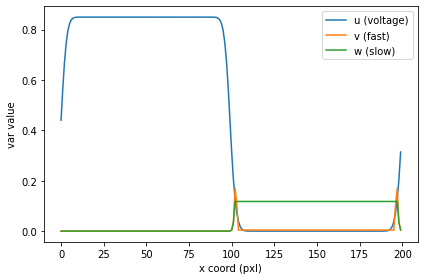

In [35]:
save = True
save_fn = f'fig/{fn}_tt_tau_v1221.png'
plt.plot(txt_out[100,:,0], label='u (voltage)')
plt.plot(txt_out[100,:,1], label='v (fast)')
plt.plot(txt_out[100,:,2], label='w (slow)')
plt.legend()
plt.xlabel('x coord (pxl)')
plt.ylabel('var value')
if not save:
    plt.show()
else:
    plt.tight_layout()
    plt.savefig(save_fn, dpi = 200)

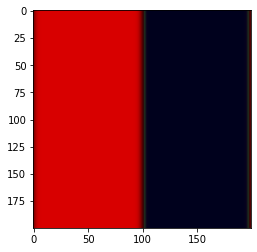

In [15]:
plt.imshow(txt_out)

## load disorder ic and apply my time_step
Our numerical values do not agree, and I can't tell why.  

Thus, I will 
- DONE: quantify the numerical difference between test B (chaotic) in terms of (printing) MSD
- TODO(WJ beat me to it. Kudos!): skim WJ's fortran to try to find out why both of my auxiliary variables jump while only one of his does (control+ F for v)
- DONE: put it all into a .pdf visualization and share!

In [275]:
fn = 'input_disorder'
save_fn = f'fig/{fn}_wj.png'
ic = import_fortran_texture(fn)

In [281]:
txt_out.dtype

dtype('float64')

In [308]:
txt = ic.copy()
zero_txt = 0.*txt.copy()
h = 0.1
for j in range(50):
    time_step(texture=txt, h=h, zero_txt=zero_txt)
txt_out = txt.copy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


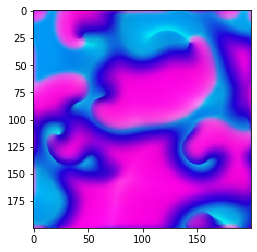

In [283]:
plt.imshow(txt_out)

In [286]:
file_name = 'output_disorder_tt.npz'
np.savez_compressed(file_name,txt_out)

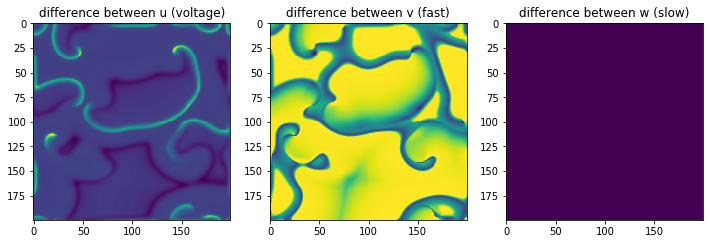

In [112]:
fn = 'output_disorder'
save_fn = f'fig/differences_tau_v1221.png'
wj_out = import_fortran_texture(fn)

diff = wj_out-txt_out
fig, axs = plt.subplots(ncols = 3, figsize=(12,4))

ax = axs[0]
ax.imshow(diff[...,0])
ax.set_title('difference between u (voltage)')
ax = axs[1]
ax.imshow(diff[...,1])
ax.set_title('difference between v (fast)')
ax = axs[2]
ax.imshow(diff[...,2])
ax.set_title('difference between w (slow)')
fig.savefig(save_fn)


In [113]:
MSD = sum(diff.flatten()**2)
# print(f"The repolarized regions of our fast variables appear to disagree.")
print(f"The mean squared difference between u is {sum(diff[...,0].flatten()**2)}")
print(f"The mean squared difference between v is {sum(diff[...,1].flatten()**2)}")
print(f"The mean squared difference between w is {sum(diff[...,2].flatten()**2)}")

The mean squared difference between u is 5.621146501665404e-12
The mean squared difference between v is 9.238808252685931e-14
The mean squared difference between w is 0.0


In [9]:
# diff[...,0]

# computational check of the time_step_kernel implemented with pycuda

## test against the half plane initial condition

In [97]:

folder_name=f"{nb_dir}/../Python/computational-checks"
os.chdir(folder_name)
#import the desired initial condition
fn = 'input_half'
ic = import_fortran_texture(fn)
ic.shape

(200, 200, 3)

In [98]:
#map initial condition to the three initial scalar fields
u_initial = np.array(ic.astype(np.float32)[...,0])
v_initial = np.array(ic.astype(np.float32)[...,1])
w_initial = np.array(ic.astype(np.float32)[...,2])

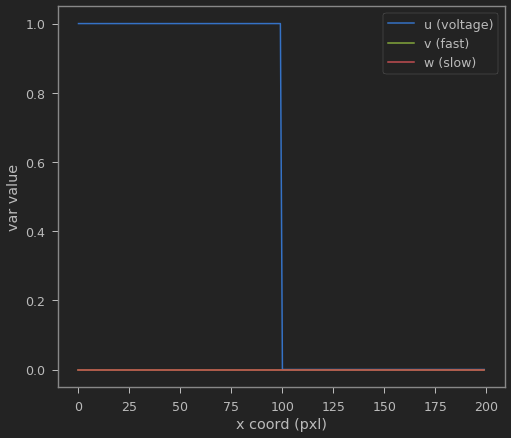

In [99]:
#compare to result from WJ and result from time_step, as before
save=False
save_fn = f'fig/{fn}_cuda_tt__tau_v1221_initial.png'
plt.plot(u_initial[100,:], label='u (voltage)')
plt.plot(v_initial[100,:], label='v (fast)')
plt.plot(w_initial[100,:], label='w (slow)')
plt.legend()
plt.xlabel('x coord (pxl)')
plt.ylabel('var value')
if not save:
    plt.show()
else:
    plt.tight_layout()
    plt.savefig(save_fn, dpi = 200)

In [100]:
from lib.utils.utils_jsonio import *
# #find file interactively
# print("please select a file from within the desired folder.")
# param_file_name = search_for_file()

#load parameters for parameter set 8 for the Fenton-Karma Model
param_file_name = '/home/timothytyree/Documents/GitHub/care/notebooks/lib/model/param_set_8.json'
kwargs = read_parameters_from_json(param_file_name)

In [101]:
# get_kernel_string_FK_model?
# 5/200
get_kernel_string_FK_model

<function lib.model.minimal_model_cuda.get_kernel_string_FK_model(DT, round_to=8, **kwargs)>

In [115]:

# kwargs['DT']

In [136]:
from lib.model.minimal_model_cuda import *
#get the time_step_kernel
width,height,chnlno=ic.shape
# kernel_string = get_kernel_string_FK_model(width=width,height=height,DX=0.025, DT=0.1,**kwargs)
# kernel_string = get_kernel_string_FK_model(width=width,height=height,DX=0.025, DT=0.0001,**kwargs)
kwargs['diffCoef']=0.001
kernel_string = get_kernel_string_FK_model( DX=0.025,DT=0.01,width=width,height=height, ,**kwargs)


SyntaxError: invalid syntax (<ipython-input-136-b1822a00faac>, line 7)

In [137]:
#initialize PyCuda and get compute capability needed for compilation
context = drv.Device(0).make_context()
devprops = { str(k): v for (k, v) in context.get_device().get_attributes().items() }
cc = str(devprops['COMPUTE_CAPABILITY_MAJOR']) + str(devprops['COMPUTE_CAPABILITY_MINOR'])

#define how resources are used
# width  = kwargs['width']
# height = kwargs['height']
threads = (10,10,1)
grid = (int(width/10), int(height/10), 1)
block_size_string = "#define block_size_x 10\n#define block_size_y 10\n"

#don't allocate memory many times for the same task!
#allocate GPU memory for voltage scalar field
u_old = drv.mem_alloc(u_initial.nbytes)
u_new = drv.mem_alloc(u_initial.nbytes)

#allocate GPU memory for v and w auxiliary fields
v_old = drv.mem_alloc(v_initial.nbytes)
v_new = drv.mem_alloc(v_initial.nbytes)
w_old = drv.mem_alloc(w_initial.nbytes)
w_new = drv.mem_alloc(w_initial.nbytes)

In [138]:
#compute the time step for the correct number of iterations = steps/2
iterations = 25

#setup thread block dimensions and compile the kernel
mod = SourceModule(block_size_string+kernel_string)
time_step_kernel = mod.get_function("time_step_kernel")

#create events for measuring performance
start = drv.Event()
end = drv.Event()

#move the data to the GPU
drv.memcpy_htod(u_old, u_initial)
drv.memcpy_htod(u_new, u_initial)
drv.memcpy_htod(v_old, v_initial)
drv.memcpy_htod(v_new, v_initial)
drv.memcpy_htod(w_old, w_initial)
drv.memcpy_htod(w_new, w_initial)

#call the GPU kernel 2*iterations times and measure performance
context.synchronize()
start.record()
for i in range(iterations):
    time_step_kernel(u_new, u_old, v_new, v_old, w_new, w_old, block=threads, grid=grid)
    time_step_kernel(u_old, u_new, v_old, v_new, w_old, w_new, block=threads, grid=grid)
end.record()
context.synchronize()
runtime = end.time_since(start)
print(f"{iterations*2} time steps took {runtime:.0f} ms.")

#copy the result from the GPU to Python for plotting
gpu_result_u = np.zeros_like(u_initial)
drv.memcpy_dtoh(gpu_result_u, u_new)
gpu_result_v = np.zeros_like(v_initial)
drv.memcpy_dtoh(gpu_result_v, v_new)
gpu_result_w = np.zeros_like(w_initial)
drv.memcpy_dtoh(gpu_result_w, w_new)

50 time steps took 7 ms.


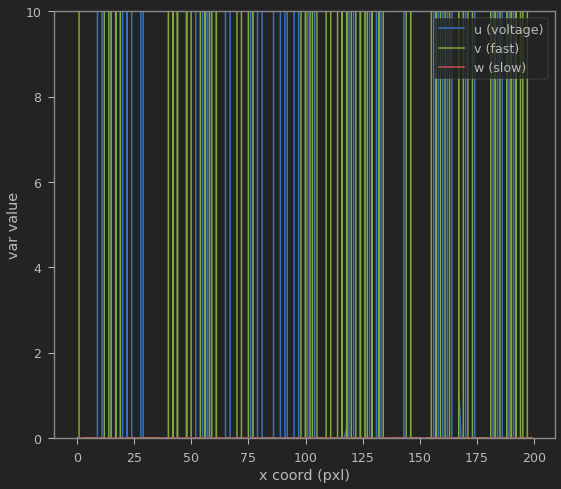

In [139]:
#compare to result from WJ and result from time_step, as before
save=True
save_fn = f'fig/{fn}_cuda_tt__tau_v1221.png'
plt.plot(gpu_result_u[100,:], label='u (voltage)')
plt.plot(gpu_result_v[100,:], label='v (fast)')
plt.plot(gpu_result_w[100,:], label='w (slow)')
plt.ylim([0,10])
plt.legend()
plt.xlabel('x coord (pxl)')
plt.ylabel('var value')
if not save:
    plt.show()
else:
    plt.tight_layout()
    plt.savefig(save_fn, dpi = 200)

## test against the disordered initial condition

- large disagreements detected in all three channels after 50 time steps.
- simulating 10**6 time steps led to a broken simulation
- error is either:
    1. from the single point float precision
        - TODO: does my gpu even support double?  If so, how do I access it through pycuda?
        - TODO: test this by finding out how to use double point percision.  is it as easy as switching all fo the `float` to `double`?
    1. from an edge case on the boundary
        - TODO: test this by trying variations on the theme, `if (x>=0 && x<nx && y>=0 && y<ny) {{`
        - TODO: failing ^that test this by running the `__host__` version of `_pbc` through my unit test for p.b.c
    1. from something else
        - TODO: develop a simple method to write gpu value to .png.
            - TODO(bonus): do this without first writing to host from device memory...
        - TODO: regularly write a .png to a file of the form `fig/*/*.00x.png`
        - TODO: develop a function that concatenates a folder of .png into a .mov or .avi.  Consider opencv2 solutions...

### initialize

In [2]:
#import the desired initial condition
fn = 'input_disorder'
ic = import_fortran_texture(fn)

NameError: name 'import_fortran_texture' is not defined

In [264]:
#map initial condition to the three initial scalar fields
u_initial = np.array(ic.astype(np.float64)[...,0])
v_initial = np.array(ic.astype(np.float64)[...,1])
w_initial = np.array(ic.astype(np.float64)[...,2])

# #map initial condition to the three initial scalar fields
# u_initial = np.array(ic.astype(np.float32)[...,0])
# v_initial = np.array(ic.astype(np.float32)[...,1])
# w_initial = np.array(ic.astype(np.float32)[...,2])

In [265]:
from lib.utils_jsonio import *
# #find file interactively
# print("please select a file from within the desired folder.")
# param_file_name = search_for_file()

#load parameters for parameter set 8 for the Fenton-Karma Model
param_file_name = '/home/timothytyree/Documents/GitHub/care/notebooks/lib/param_set_8.json'
kwargs = read_parameters_from_json(param_file_name)

In [266]:
from lib.minimal_model_cuda import *
#get the time_step_kernel
kernel_string = get_kernel_string_FK_model(**kwargs, DT=0.1)


In [267]:
#initialize PyCuda and get compute capability needed for compilation
context = drv.Device(0).make_context()
devprops = { str(k): v for (k, v) in context.get_device().get_attributes().items() }
cc = str(devprops['COMPUTE_CAPABILITY_MAJOR']) + str(devprops['COMPUTE_CAPABILITY_MINOR'])

#define how resources are used
width  = kwargs['width']
height = kwargs['height']
threads = (10,10,1)
grid = (int(width/10), int(height/10), 1)
block_size_string = "#define block_size_x 10\n#define block_size_y 10\n"

#don't allocate memory many times for the same task!
#allocate GPU memory for voltage scalar field
u_old = drv.mem_alloc(u_initial.nbytes)
u_new = drv.mem_alloc(u_initial.nbytes)

#allocate GPU memory for v and w auxiliary fields
v_old = drv.mem_alloc(v_initial.nbytes)
v_new = drv.mem_alloc(v_initial.nbytes)
w_old = drv.mem_alloc(w_initial.nbytes)
w_new = drv.mem_alloc(w_initial.nbytes)

### fiddle with the time_step_kernel with double floating point precision

In [230]:
def get_kernel_string_FK_model(width, height, DX, DT, diffCoef, C_m,
                               tau_pv, tau_v1, tau_v2, tau_pw, tau_mw, tau_d,
                               tau_0, tau_r, tau_si, K, V_sic, V_c, V_v, round_to=8):
    return f"""
// primary model parameters
#define width  {int(width)}
#define height {int(height)}
#define h      {float(DT)}
#define C_m    {float(C_m)}
#define tau_pv {float(tau_pv)}
#define tau_v1 {float(tau_v1)}
#define tau_v2 {float(tau_v2)}
#define tau_pw {float(tau_pw)}
#define tau_mw {float(tau_mw)}
#define tau_d  {float(tau_d)}
#define tau_0  {float(tau_0)}
#define tau_r  {float(tau_r)}
#define tau_si {float(tau_si)}
#define K      {float(K)}
#define V_sic  {float(V_sic)}
#define V_c    {float(V_c)}
#define V_v    {float(V_v)}

// auxiliary model parameters
#define nx width
#define ny height
#define dcoef {float(diffCoef/DX**2):.{round_to}f}

// periodic boundary conditions
__device__ int _pbc ( int q, int wid ) {{
    if (q >= wid) {{
        q = 0;
    }}
    if (q < 0) {{
        q = wid-1;
    }}
    return q;
}}

// heaviside step function
__device__ double step(double thresh, double x)
{{
    return x >= thresh;
}}

// main computation kernel/face shader
__global__ void time_step_kernel(double *u_new, double *u, double *v_new, double *v, double *w_new, double *w) {{
    int x = blockIdx.x * block_size_x + threadIdx.x;
    int y = blockIdx.y * block_size_y + threadIdx.y;
    if (x>=0 && x<nx && y>=0 && y<ny) {{
            double U = u[y*nx+x];
            double V = v[y*nx+x];
            double W = w[y*nx+x];
            double p = step(V_c, U);
            double q = step(V_v, U);
            //WJ's modification of the FK model
            double tau_mv = (1.0 - q) * tau_v2 + q * tau_v1 ;
            ////the unmodified FK model
            //double tau_mv = (1.0 - q) * tau_v1 + q * tau_v2 ;

            // local ion current terms
            double tn  = tanh( K * (U - V_sic)) ;
            double Ifi = -V * p * (U - V_c) * (1.0 - U) / tau_d ;
            double Iso = U * (1.0 - p) / tau_0 + p / tau_r ;
            double Isi = -W * (1.0 + tn ) / (2.0 * tau_si) ;
            double I_sum = Ifi + Iso + Isi ;
            double current_term = -I_sum / C_m ;

            // local transient terms for auxiliary variables
            double dVdt = (1.0 - p) * (1.0 - V) / tau_mv - p * V / tau_pv ;
            double dWdt = (1.0 - p) * (1.0 - W) / tau_mw - p * W / tau_pw ;

            // diffusion term (5-point stencil)
            int up    = _pbc(y+1,height);
            int down  = _pbc(y-1,height);
            int left  = _pbc(x-1, width);
            int right = _pbc(x+1, width);
            double diffusion_term =  dcoef * (
            u[(up)*nx+x]+u[y*nx+right]
            -4.0f*u[y*nx+x]
            +u[y*nx+left]+u[(down)*nx+x]
            );

            //integrate in time
            double dUdt = diffusion_term + current_term ;
            u_new[y*nx+x] = U + h * dUdt;
            v_new[y*nx+x] = V + h * dVdt;
            w_new[y*nx+x] = W + h * dWdt;
    }}
}}
    """

#get the time_step_kernel
kernel_string = get_kernel_string_FK_model(**kwargs, DT=0.1)

### compute the time step

In [268]:
#compute the time step for the correct number of iterations = steps/2
iterations = 25
# iterations = #2 min of simulation time took 2 minutes of real time : 10**6#25

#setup thread block dimensions and compile the kernel
mod = SourceModule(block_size_string+kernel_string)
time_step_kernel = mod.get_function("time_step_kernel")

#create events for measuring performance
start = drv.Event()
end = drv.Event()

#move the data to the GPU
drv.memcpy_htod(u_old, u_initial)
drv.memcpy_htod(u_new, u_initial)
drv.memcpy_htod(v_old, v_initial)
drv.memcpy_htod(v_new, v_initial)
drv.memcpy_htod(w_old, w_initial)
drv.memcpy_htod(w_new, w_initial)

#call the GPU kernel 2*iterations times and measure performance
context.synchronize()
start.record()
for i in range(iterations):
    time_step_kernel(u_new, u_old, v_new, v_old, w_new, w_old, block=threads, grid=grid)
    time_step_kernel(u_old, u_new, v_old, v_new, w_old, w_new, block=threads, grid=grid)
end.record()
context.synchronize()
runtime = end.time_since(start)
print(f"{iterations*2} time steps took {runtime:.0f} ms.")

# #copy the result from the GPU to Python for plotting
# gpu_result_u = np.zeros_like(u_initial)
# drv.memcpy_dtoh(gpu_result_u, u_new)
# gpu_result_v = np.zeros_like(v_initial)
# drv.memcpy_dtoh(gpu_result_v, v_new)
# gpu_result_w = np.zeros_like(w_initial)
# drv.memcpy_dtoh(gpu_result_w, w_new)

#copy the result from the GPU to Python for plotting
gpu_result_u = np.zeros_like(u_initial)
drv.memcpy_dtoh(gpu_result_u, u_old)
gpu_result_v = np.zeros_like(v_initial)
drv.memcpy_dtoh(gpu_result_v, v_old)
gpu_result_w = np.zeros_like(w_initial)
drv.memcpy_dtoh(gpu_result_w, w_old)

50 time steps took 8 ms.


In [269]:
txt_out_gpu = np.stack((gpu_result_u,gpu_result_v,gpu_result_w),axis=2)
diff = wj_out-txt_out_gpu
MSD = sum(diff.flatten()**2)
# print(f"The repolarized regions of our fast variables appear to disagree.")
print(f"The mean squared difference between u is {sum(diff[...,0].flatten()**2)}")
print(f"The mean squared difference between v is {sum(diff[...,1].flatten()**2)}")
print(f"The mean squared difference between w is {sum(diff[...,2].flatten()**2)}")

The mean squared difference between u is 5.621146482882154e-12
The mean squared difference between v is 9.238808270631908e-14
The mean squared difference between w is 1.00579765415679e-29


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


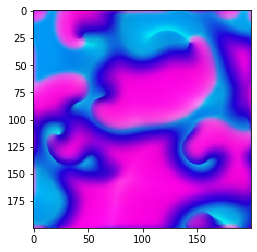

In [270]:
plt.imshow(txt_out_gpu)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


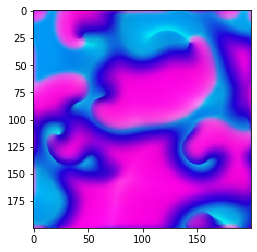

In [295]:
# plt.imshow(wj_out)
plt.imshow(txt_out)

LLVM time step - CUDA time step
The sum of squared differences between u is 1.066119497177146e-28
The sum of squared differences between v is 1.1687551774333596e-29
The sum of squared differences between w is 1.00579765415679e-29


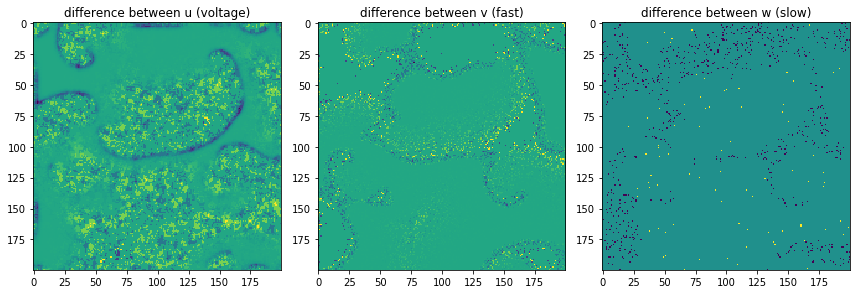

In [315]:
save=True
save_fn = f'fig/differences_gpu_wj_tau_v1221_double.png'
fn = 'output_disorder'
wj_out = import_fortran_texture(fn)
file_name = 'output_disorder_tt.npz'
txt_out   = np.load(file_name)['arr_0']
diff = txt_out-txt_out_gpu
# diff = wj_out-txt_out_gpu
# pad = 1
# diff = diff[pad:-pad,pad:-pad]
fig, axs = plt.subplots(ncols = 3, figsize=(12,4))

print(f'LLVM time step - CUDA time step')
ax = axs[0]
ax.imshow(diff[...,0])
ax.set_title('difference between u (voltage)')
ax = axs[1]
ax.imshow(diff[...,1])
ax.set_title('difference between v (fast)')
ax = axs[2]
ax.imshow(diff[...,2])
ax.set_title('difference between w (slow)')
if not save:
    plt.show()
else:
    plt.tight_layout()
    plt.savefig(save_fn, dpi = 200)


MSD = sum(diff.flatten()**2)
# print(f"The repolarized regions of our fast variables appear to disagree.")
print(f"The sum of squared differences between u is {sum(diff[...,0].flatten()**2)}")
print(f"The sum of squared differences between v is {sum(diff[...,1].flatten()**2)}")
print(f"The sum of squared differences between w is {sum(diff[...,2].flatten()**2)}")

In [118]:
np.float32(np.pi)

3.1415927

In [119]:
np.float64(np.pi)

3.141592653589793

I think the problem could be in the diffusion term near the boundaries.
    - TODO: try swapping out double for float everywhere
    - ***DONE: try varying some edge case variables and see if the problem goes away for the most part***
    
This might have fixed it
```
// periodic boundary conditions
__device__ int _pbc ( int q, int wid ) {{
    if (q >= wid) {{
        q = 0;
    }}
    if (q < 0) {{
        q = wid-1;
    }}
    return q;
}}

```

# computational checks for LR model

In [1]:
from lib.my_initialization import *
%autocall 1
%load_ext autoreload
%autoreload 2
# awareness&chill

Automatic calling is: Smart


__goto__ - 'Luo-Rudy Model.ipynb' and see chapter `Action potentials from the LR model in 0D` for a computational check _versus_ the result of ./lib/model/comp_check_LR/run_test_LR.sh _with respect to_ voltage as a function of time.

In [2]:
#load results from earlier
os.chdir(os.path.join(nb_dir,'Figures/methods'))
df=pd.read_csv('LR_action_potentials_optimized.csv')

In [8]:
#load WJ's results
os.chdir(os.path.join(nb_dir,'lib/model/comp_check_LR'))
wj=np.loadtxt('fort.1')
wj.shape

(500, 4)

In [9]:
col1,col1,col3,col4=wj.T

In [11]:
V=col1


In [21]:
t_values=df.t.values[:5000]
V_values=df.V.values[:5000]

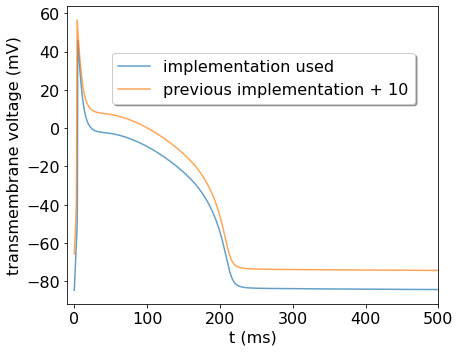

In [34]:
#voltage
fontsize=16
save=True

plt.subplots(figsize=(6.5,5))
plt.plot(t_values,V_values,alpha=0.7,label='implementation used')
plt.plot(V+10,alpha=0.7,label='previous implementation + 10')

# plt.y_label
# plt.plot(t_values,V_values,c='k')
plt.legend(ncol=1, fontsize=fontsize, bbox_to_anchor=(.1,.87), fancybox=True, shadow=True)
# plt.yscale('log')
plt.tick_params(labelsize=fontsize)
plt.xlabel(r't (ms)', fontsize=fontsize)
plt.tight_layout()
plt.xlim([-10,500])
plt.ylabel('transmembrane voltage (mV)', fontsize=fontsize)
# plt.xlim([-10,200])
if not save:
    plt.show()
else:
    os.chdir(os.path.join(nb_dir,'Figures/methods'))
    savefig_fn='comp_check_LR.png'
    plt.tight_layout()
    plt.savefig(savefig_fn,dpi=300)

In [ ]:
plt.plot(t_values,V_values,alpha=0.7,label='implementation used')
plt.plot(V+10,alpha=0.7,label='previous implementation + 10')


In [72]:
diff_values= V[:-1]-V_values[11::10]

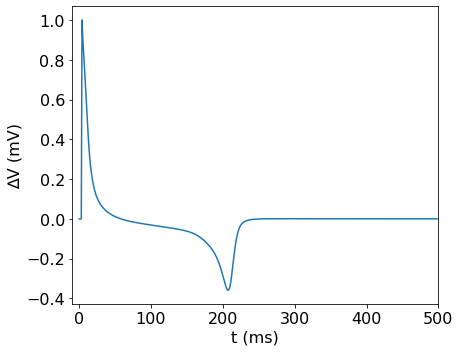

In [76]:
#voltage
fontsize=16
save=True

plt.subplots(figsize=(6.5,5))
plt.plot(diff_values)
# plt.y_label
# plt.plot(t_values,V_values,c='k')
# plt.legend(ncol=1, fontsize=fontsize, bbox_to_anchor=(.1,.87), fancybox=True, shadow=True)
# plt.yscale('log')
plt.tick_params(labelsize=fontsize)
plt.xlabel(r't (ms)', fontsize=fontsize)
plt.tight_layout()
plt.xlim([-10,500])
plt.ylabel('∆V (mV)', fontsize=fontsize)
# plt.xlim([-10,200])
if not save:
    plt.show()
else:
    os.chdir(os.path.join(nb_dir,'Figures/methods'))
    savefig_fn='comp_check_LR_disagreement.png'
    plt.tight_layout()
    plt.savefig(savefig_fn,dpi=300)

In [77]:
V[:10]

array([-75.66009528, -67.72791026, -59.75680868, -47.07901316,
        46.51283733,  40.47395399,  34.76213201,  29.59991774,
        24.96937707,  20.85813971])

In [78]:
V_values[11::10][:10]

array([-75.66009576, -67.72791078, -59.75680922, -47.0790167 ,
        45.51283453,  39.56200062,  33.91137553,  28.8118335 ,
        24.24588332,  20.20174787])

The apparent disagreement may be the result of accumulated error resulting from floating point arithmetic.  Fortran handles this differently from Python, as memory serves.  This is an excitable system, after all.

# test cuda time step

In [4]:
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from lib.utils.utils_jsonio import *
from lib.model.minimal_model_cuda import *

#the following might be needed for the kernel_autotuner.
drv.init()
#initialize PyCuda and get compute capability needed for compilation
context = drv.Device(0).make_context()
devprops = { str(k): v for (k, v) in context.get_device().get_attributes().items() }
cc = str(devprops['COMPUTE_CAPABILITY_MAJOR']) + str(devprops['COMPUTE_CAPABILITY_MINOR'])
#load parameters for parameter set 8 for the Fenton-Karma Model
param_file_name = '/home/timothytyree/Documents/GitHub/care/notebooks/lib/model/param_set_8.json'
kwargs = read_parameters_from_json(param_file_name)
#load parameters for parameter set 8 for the Fenton-Karma Model
# kwargs = read_parameters_from_json('lib/model/param_set_8.json')

#define how resources are used
# width  = kwargs['width']
# height = kwargs['height']
threads = (10,10,1)
grid = (int(width/10), int(height/10), 1)
block_size_string = "#define block_size_x 10\n#define block_size_y 10\n"

#define the initial conditions
Vin  = np.array([1*x*(y+1) for x in range(width) for y in range(height)]).reshape((width,height))

u_initial = Vin.astype(np.float64)
#initialize auxiliary textures to zero
v_initial = np.zeros_like(u_initial)
w_initial = np.zeros_like(u_initial)

#don't allocate memory many times for the same task!
#allocate GPU memory for voltage scalar field
u_old = drv.mem_alloc(u_initial.nbytes)
u_new = drv.mem_alloc(u_initial.nbytes)

#allocate GPU memory for v and w auxiliary fields
v_old = drv.mem_alloc(v_initial.nbytes)
v_new = drv.mem_alloc(v_initial.nbytes)
w_old = drv.mem_alloc(w_initial.nbytes)
w_new = drv.mem_alloc(w_initial.nbytes)

# explicit time integration up to 5 seconds in steps of size 0.025 ms
kernel_string = get_kernel_string_FK_model( DX=0.025,DT=0.025,width=width,height=height,**kwargs)
iterations = 10**5

#setup thread block dimensions and compile the kernel
mod = SourceModule(block_size_string+kernel_string)
time_step_kernel = mod.get_function("time_step_kernel")

#create events for measuring performance
start = drv.Event()
end = drv.Event()

#move the data to the GPU
drv.memcpy_htod(u_old, u_initial)
drv.memcpy_htod(u_new, u_initial)
drv.memcpy_htod(v_old, v_initial)
drv.memcpy_htod(v_new, v_initial)
drv.memcpy_htod(w_old, w_initial)
drv.memcpy_htod(w_new, w_initial)

#call the GPU kernel 2*iterations times and measure performance
context.synchronize()
start.record()
for i in range(iterations):
    time_step_kernel(u_new, u_old, v_new, v_old, w_new, w_old, block=threads, grid=grid)
    time_step_kernel(u_old, u_new, v_old, v_new, w_old, w_new, block=threads, grid=grid)
end.record()
context.synchronize()
runtime = end.time_since(start)
print(f"{iterations*2} time steps took {runtime:.0f} ms.")

#copy the result from the GPU to Python for plotting
gpu_result_u = np.zeros_like(u_initial)
drv.memcpy_dtoh(gpu_result_u, u_old)
gpu_result_v = np.zeros_like(v_initial)
drv.memcpy_dtoh(gpu_result_v, v_old)
gpu_result_w = np.zeros_like(w_initial)
drv.memcpy_dtoh(gpu_result_w, w_old)

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2, figsize=(6,10))
ax1.imshow(u_initial)
ax1.set_title("Initial Conditions\n$u_0$")
ax2.imshow(gpu_result_u)
ax2.set_title("Final Result From GPU\n$u$")

ax3.imshow(v_initial)
ax3.set_title("$v_0$")
ax4.imshow(gpu_result_v)
ax4.set_title("$v$")

ax5.imshow(w_initial)
ax5.set_title("$w_0$")
ax6.imshow(gpu_result_w)
ax6.set_title("$w$")
plt.show()


NameError: name 'width' is not defined

In [62]:
beep(3)

0

In [64]:

200000*0.025

5000.0